# Baseline for LimeSoda: TF-IDF + nbSVM

## Installing dependencies

In [4]:
!pip install -q pythainlp sklearn tqdm pandas torch emoji seaborn

You should consider upgrading via the '/samsung-4tb/cp-eng/pattern/course-projects/pattern-env/bin/python -m pip install --upgrade pip' command.


In [2]:
# %cd /samsung-4tb/cp-eng/pattern/course-projects
%cd /workspace
import json
import re

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from tqdm.auto import tqdm

from baseline.tokenizer import tokenize
from baseline.model import NbSVC, NbLogisticRegression
from baseline.evaluate import evaluate

# LIMESODA_DIR = "/samsung-4tb/cp-eng/pattern/course-projects/dataset/LimeSoda/"
LIMESODA_DIR = "/workspace/dataset/LimeSoda/"
DELIMITER = " "

/workspace


## Preparing Data

Quoted from LimeSoda Paper

> The training dataset consists of two parts where each
document in both parts are labeled as “Fact” or “Fake”. The
**undefined categories are disregarded** due to the assumption
that every healthcare-related news will fall into fact or fake
sets which could be the noise. For the preliminary analysis,
we simplify the multi-label token tags into the binary vector
or HAM for comparing the attentive similarity to humans.

> **We use the first part as our training set with 10% of that are
randomly selected to be our validation set. Then, the second
part is used as our test set.** The models are trained as a binary
classification task. We do not use the tags from experts to
supervise the attention weights, allowing the models to learn
to attend independently

In [3]:
def read_limesoda(delimiter=" "):
    train, val, test = [], [], []
    mapper = {"Fake News": 0, "Fact News": 1}
    
    # train
    with open(f"{LIMESODA_DIR}//../tempLimesoda/train_v1.jsonl", "r") as f:
        for line in tqdm(f.readlines()):
            line = json.loads(line)
            line["label"] = mapper[line["Document Tag"]]
            line["text"] = delimiter.join([t for t in line["Text"] if len(t.strip()) > 0])
            line.pop("Document Tag")
            line.pop("Text")
            train.append(line)
           
    # val
    with open(f"{LIMESODA_DIR}//../tempLimesoda/val_v1.jsonl", "r") as f:
        for line in tqdm(f.readlines()):
            line = json.loads(line)
            line["label"] = mapper[line["Document Tag"]]
            line["text"] = delimiter.join([t for t in line["Text"] if len(t) > 0])
            line.pop("Document Tag")
            line.pop("Text")
            val.append(line)
            
    with open(f"{LIMESODA_DIR}//../tempLimesoda/test_v1.jsonl", "r") as f:
        for line in tqdm(f.readlines()):
            line = json.loads(line)
            if line["Document Tag"] not in mapper.keys():
                continue
            line["label"] = mapper[line["Document Tag"]]
            line["text"] = delimiter.join([t for t in line["Text"] if len(t) > 0])
            line.pop("Document Tag")
            line.pop("Text")
            test.append(line)

    return {
        "train": pd.DataFrame(train),
        "val": pd.DataFrame(val),
        "test": pd.DataFrame(test)
    }
            
dataset = read_limesoda(delimiter=DELIMITER)

  0%|          | 0/2698 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2765 [00:00<?, ?it/s]

In [4]:
dataset["train"]

,label,text
0,1,"เพื่อน ๆ รู้ ไหม ครับ ว่า "" การ ล้าง มือ "" มี ..."
1,1,เทรนด์ กิ๊บเก๋ ... ป้องกัน โรค ||| ฮัดเช้ยยยย ...
2,1,สถาน เอกอัครราชทูต คูเวต งด ออกวี ซ่า แก่ คน ต...
3,1,"สั่ง ตรวจสอบ "" ลูก ตุ้ม พลังธาตุ "" ของขลัง ฆ่า..."
4,0,เรา ไม่ รู้ ว่า Covid - 19 กลัว ขิง กับ กัญชา ...
...,...,...
2693,0,SaaPannisa ไข่ มุก นั้น ทำ มา จาก แป้ง มันสำปะ...
2694,1,ออก กำลัง กาย ไล่ ความ ดัน โลหิต สูง ||| โดย ก...
2695,1,‘ ผู้ ชาย - คน อ้วน ’ เสี่ยง ป่วย หนักหาก ติด ...
2696,0,กระเทียม สุด ยอด ผัก จริง ๆ ตั้งแต่ ค . แข็ง ย...


## EDA

In [172]:
with open(f"{LIMESODA_DIR}//../tempLimesoda/test_v1.jsonl", "r") as f:
    lines = f.readlines()
pd.Series([json.loads(l)["Document Tag"] for l in lines]).value_counts()

Undefined    2327
Fake News     401
Fact News      37
dtype: int64

In [173]:
with open(f"{LIMESODA_DIR}//../tempLimesoda/train_v1.jsonl", "r") as f:
    lines = f.readlines()
pd.Series([json.loads(l)["Document Tag"] for l in lines]).value_counts()

Fact News    1369
Fake News    1329
dtype: int64

In [174]:
with open(f"{LIMESODA_DIR}//../tempLimesoda/val_v1.jsonl", "r") as f:
    lines = f.readlines()
pd.Series([json.loads(l)["Document Tag"] for l in lines]).value_counts()

Fact News    152
Fake News    148
dtype: int64

In [175]:
len(dataset["test"])

438

In [176]:
len(dataset["val"])

300

In [177]:
len(dataset["train"])

2698

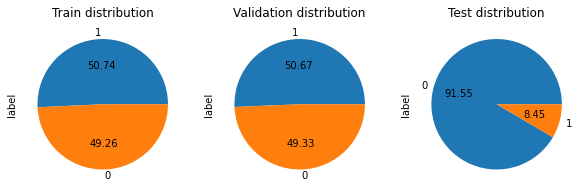

In [178]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 3, figsize=(10, 3))
dataset["train"]["label"].value_counts().plot.pie(autopct="%.2f", ax=ax[0])
dataset["val"]["label"].value_counts().plot.pie(autopct="%.2f", ax=ax[1])
dataset["test"]["label"].value_counts().plot.pie(autopct="%.2f", ax=ax[2])

ax[0].set_title("Train distribution")
ax[1].set_title("Validation distribution")
ax[2].set_title("Test distribution")
plt.show()

## Definining Pipeline

In [179]:
parameters_grid = {
    # tfidf grids
    "tfidf__ngram_range": [[1, 2]],
    "tfidf__min_df": [5, 7],
    "tfidf__max_df": [0.5, 0.6],
    "tfidf__use_idf": [True],
    "tfidf__smooth_idf": [True, False],
    "tfidf__sublinear_tf": [True, False],
    "tfidf__tokenizer": [lambda x: x.split(DELIMITER)],
    "tfidf__token_pattern": [None],

    # clf grids
    "clf__alpha": [0.5, 0.75],
    # "clf__kernel": ["rbf", "linear"],
    # "clf__gamma": "scale",
    "clf__C": [1.],
}

In [180]:
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", NbLogisticRegression())
])

In [181]:
clf = GridSearchCV(
    estimator=pipeline,
    param_grid=parameters_grid,
    scoring="accuracy",
    n_jobs=-1,
)

## Grid Search

In [182]:
x_train, y_train = dataset["train"]["text"].values, dataset["train"]["label"].values
x_val, y_val = dataset["val"]["text"].values, dataset["val"]["label"].values
x_test, y_test = dataset["test"]["text"].values, dataset["test"]["label"].values

In [183]:
clf.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', NbLogisticRegression())]),
             n_jobs=-1,
             param_grid={'clf__C': [1.0], 'clf__alpha': [0.5, 0.75],
                         'tfidf__max_df': [0.5, 0.6], 'tfidf__min_df': [5, 7],
                         'tfidf__ngram_range': [[1, 2]],
                         'tfidf__smooth_idf': [True, False],
                         'tfidf__sublinear_tf': [True, False],
                         'tfidf__token_pattern': [None],
                         'tfidf__tokenizer': [<function <lambda> at 0x7fd5efa3bdc0>],
                         'tfidf__use_idf': [True]},
             scoring='accuracy')

In [184]:
clf.best_params_

{'clf__C': 1.0,
 'clf__alpha': 0.5,
 'tfidf__max_df': 0.5,
 'tfidf__min_df': 5,
 'tfidf__ngram_range': [1, 2],
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': True,
 'tfidf__token_pattern': None,
 'tfidf__tokenizer': <function __main__.<lambda>(x)>,
 'tfidf__use_idf': True}

## Baseline
Mode prediction.

In [185]:
pd.Series(y_train).value_counts()

1    1369
0    1329
dtype: int64

In [186]:
import numpy as np
from sklearn.metrics import classification_report

print(classification_report(y_test, np.zeros_like(y_test), digits=4))

              precision    recall  f1-score   support

           0     0.9155    1.0000    0.9559       401
           1     0.0000    0.0000    0.0000        37

    accuracy                         0.9155       438
   macro avg     0.4578    0.5000    0.4779       438
weighted avg     0.8382    0.9155    0.8752       438



/samsung-ssd/works/cp-master/pattern/course-projects/pattern-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/samsung-ssd/works/cp-master/pattern/course-projects/pattern-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/samsung-ssd/works/cp-master/pattern/course-projects/pattern-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

## Evaluation

In [187]:
y_pred = clf.predict(x_test)

In [188]:
results = evaluate(clf, x_test, y_test)
_ = results.pop("prediction")

In [189]:
results

{'accuracy': {'overall': 0.863013698630137, 'average': 0.8147873559344881},
 'recall': {'micro': 0.863013698630137, 'macro': 0.8147873559344881},
 'precision': {'micro': 0.863013698630137, 'macro': 0.6646803709319136},
 'f1': {'micro': 0.863013698630137, 'macro': 0.7019056261343013},
 'confusion_matrix': {'none': [[350, 51], [9, 28]],
  'true': [[0.8728179551122195, 0.12718204488778054],
   [0.24324324324324326, 0.7567567567567568]],
  'pred': [[0.9749303621169917, 0.6455696202531646],
   [0.025069637883008356, 0.35443037974683544]]}}

<AxesSubplot:>

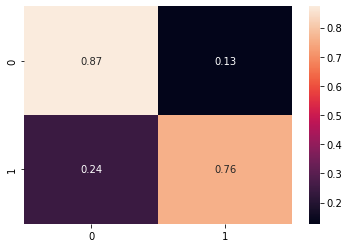

In [190]:
sns.heatmap(results["confusion_matrix"]["true"], annot=True)

# Full pipeline

In [ ]:
parameters_grid = {
    # tfidf grids
    "tfidf__ngram_range": [[1, 2]],
    "tfidf__min_df": [5, 7],
    "tfidf__max_df": [0.5, 0.6],
    "tfidf__use_idf": [True],
    "tfidf__smooth_idf": [True, False],
    "tfidf__sublinear_tf": [True, False],
    "tfidf__tokenizer": [lambda x: x.split(DELIMITER)],
    "tfidf__token_pattern": [None],

    # clf grids
    "clf__alpha": [0.5, 0.75],
    # "clf__kernel": ["rbf", "linear"],
    # "clf__gamma": "scale",
    "clf__C": [1.],
}

dataset = read_limesoda(delimiter=DELIMITER)

for data_percentage in (1., 0.8, 0.6, 0.4):
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer()),
        ("clf", NbLogisticRegression())
    ])
    
    clf = GridSearchCV(
        estimator=pipeline,
        param_grid=parameters_grid,
        scoring="accuracy",
        n_jobs=-1,
    )
    
    
    train_data = dataset["train"].iloc[:int(len(dataset["train"])*data_percentage)]
    x_train, y_train = train_data["text"].values, train_data["label"].values
    x_val, y_val = dataset["val"]["text"].values, dataset["val"]["label"].values
    x_test, y_test = dataset["test"]["text"].values, dataset["test"]["label"].values
    
    clf.fit(x_train, y_train)
    
    y_pred = clf.predict(x_test)
    
    results = evaluate(clf, x_test, y_test)
    _ = results.pop("prediction")
    
    print(f"Data Percentage: {data_percentage*100:.2f}%")
    print(f'\t> Accuracy: {results["accuracy"]["overall"]*100:.2f}%')
    print(f'\t> Macro F1: {results["f1"]["macro"]*100:.2f}%\n')